In [1]:
import os
import h5py
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score

In [2]:
from functions import (hs_generator_test, plot_regression, 
                       predictions_per_plot)

After we import the useful libraries and functions, we load tha dataset and define which model to use (Spectral for this example).

In [3]:
print('\nSHAP EXPLAINER')
gt='moisture'
pixels_per_sample=200
das=None#we use all dates
train_model='LSTM'
#train_model='SPATIAL'
avg=True

#%%
#Define main directories
main_dir='/your/directory'
data_dir=os.path.join(main_dir,'data_hs')
saving_dir=os.path.join(main_dir,'results',gt,'AZURE',train_model)
string_dir='mkdir -p '+saving_dir
os.system(string_dir)

#%%
#Load data and labels
file_name_h5=os.path.join(data_dir,'NUE_canola_hsi_dataset.hdf5')
h5f=h5py.File(file_name_h5,'r')

print('\nOpening dataset...')

print('\nGeneral information about the dataset:')
for i in h5f.attrs.keys():
      print('{} => {}'.format(i, h5f.attrs[i]))

print('\nGroups contained in dataset:')
for key in h5f.keys():
    print(key)


SHAP EXPLAINER

Opening dataset...

General information about the dataset:
creator => Julio Torres-Tello
institution => University of Saskatchewan
year => 2020
crop => canola
bands => 400-1000nm
scanner => Corning microHSI SHARK

Groups contained in dataset:
03092019_DAS95
09092019_DAS101
16082019_DAS77
16092019_DAS108
20082019_DAS81
25092019_DAS117
27082019_DAS88
30082019_DAS91


Then, we create the data generators to feed the model and load the trained model.

In [4]:
#Data generators
dim=3
if avg==True:
    average='True'
else:
    average='False'
        
test_gen=hs_generator_test(h5f, gt,
                           pixels_per_sample=pixels_per_sample, average=average,
                           dim=dim,full_sample=False, das=das)

#%%
#Load model
model_file=os.path.join(saving_dir,'model_'+train_model.lower()+'.h5')
model=load_model(model_file)
print('Trained model:')
model.summary()

Trained model:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 150, 40)           3520      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 40)           9760      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150, 40)           9760      
_________________________________________________________________
flatten (Flatten)            (None, 6000)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               720120    
_________________________________________________________________
dense_1 (Dense)              (None, 84)                10164     
_________________________________________________________________
dense_2 (Dense)              (None, 1)   

Now, we choose a sample to create the explanations.

In [5]:
#Dataset for analysis
if das==None:
    steps=128
else:
    steps=16
    
generator=test_gen

X=[]
Y=[]
X_plot=[]
Y_plot=[]
for i in range(steps):
    Xy=next(generator)
    x=Xy[0]
    y=Xy[1]
    
    X.append(x)
    Y.append(y)
    
    #per plot
    x_plot=np.mean(x,axis=0)
    y_plot=y[0]
    X_plot.append(x_plot)
    Y_plot.append(y_plot)

#%%
X=np.concatenate(X)
Y=np.concatenate(Y)

X_plot=np.asarray(X_plot)
Y_plot=np.asarray(Y_plot)


Loading group:  03092019_DAS95

Test set. Loading HS image from plot:  401
moisture => 66.2097326936258

Test set. Loading HS image from plot:  402
moisture => 57.9667282809612

Test set. Loading HS image from plot:  403
moisture => 64.2325315005727

Test set. Loading HS image from plot:  404
moisture => 60.0393700787402

Test set. Loading HS image from plot:  405
moisture => 60.9399477806789

Test set. Loading HS image from plot:  406
moisture => 59.4468855001292

Test set. Loading HS image from plot:  407
moisture => 64.4777809227286

Test set. Loading HS image from plot:  408
moisture => 62.1890547263682

Test set. Loading HS image from plot:  409
moisture => 61.504854368932

Test set. Loading HS image from plot:  410
moisture => 65.149359886202

Test set. Loading HS image from plot:  411
moisture => 63.3128834355828

Test set. Loading HS image from plot:  412
moisture => 59.9276890629708

Test set. Loading HS image from plot:  413
moisture => 62.3720349563046

Test set. Loading HS

In [6]:
#%%
#Generate dataset for explanaitions (complete test set)
background=X_plot #use average per plot, otherwise too many to visualize

print('\nBackground dataset of size: ', background.shape)


Background dataset of size:  (128, 150, 1)


In [7]:
#Shap
# init the JS visualization code
shap.initjs()

#Obtain shap values for a model
explainer=shap.GradientExplainer(model,background)

Finally, we can plot some samples.

In [8]:
shap_v=explainer.shap_values(background)

(1, 128, 150, 1)
(1, 128, 150, 1)


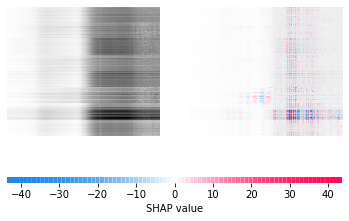

In [9]:
sv=shap_v[0].reshape(1,shap_v[0].shape[0],shap_v[0].shape[1],shap_v[0].shape[2])
print(sv.shape)
bg=background.reshape(1,background.shape[0],background.shape[1],background.shape[2])
print(bg.shape)
shap.image_plot(sv, -bg, width=50, aspect=0.1)

We could also see which spectral bands are the ones that contribute the most to the predictions of our model.

In [10]:
#Add values per feature, to find max bands
sv_add=np.sum(sv,axis=1, keepdims=True)
print(sv_add.shape)

(1, 1, 150, 1)


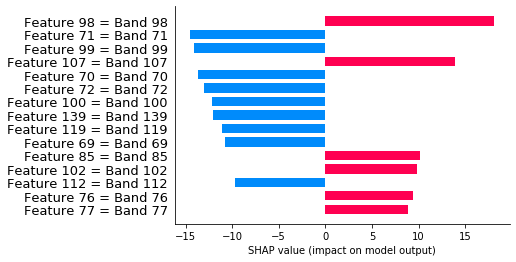

In [11]:
features=['Band '+str(i) for i in range(150)]

shap.bar_plot(sv_add[0,0,:,0],max_display=15, features=features) #plots max bands

In [12]:

#from . import colors
#from ..utils._legacy import kmeans

# .shape[0] messes up pylint a lot here
# pylint: disable=unsubscriptable-object


def plot_shap_hs(shap_values, pixel_values=None, labels=None, width=20, aspect=0.2, 
                 hspace=0.2, labelpad=None, show=True, hsi=True):
    """ Plots SHAP values for image inputs.

    Parameters
    ----------
    shap_values : [numpy.array]
        List of arrays of SHAP values. Each array has the shap (# samples x width x height x channels), and the
        length of the list is equal to the number of model outputs that are being explained.

    pixel_values : numpy.array
        Matrix of pixel values (# samples x width x height x channels) for each image. It should be the same
        shape as each array in the shap_values list of arrays.

    labels : list
        List of names for each of the model outputs that are being explained. This list should be the same length
        as the shap_values list.

    width : float
        The width of the produced matplotlib plot.

    labelpad : float
        How much padding to use around the model output labels.

    show : bool
        Whether matplotlib.pyplot.show() is called before returning. Setting this to False allows the plot
        to be customized further after it has been created.
    """
    # manage hyperspectral images
    if hsi == True:
        shap_values=shap_values[0].reshape(1,shap_values[0].shape[0],shap_values[0].shape[1],shap_values[0].shape[2])
        pixel_values=pixel_values.reshape(1,pixel_values.shape[0],pixel_values.shape[1],pixel_values.shape[2])

    # support passing an explanation object
    if str(type(shap_values)).endswith("Explanation'>"):
        shap_exp = shap_values
        feature_names = [shap_exp.feature_names]
        ind = 0
        if len(shap_exp.base_values.shape) == 2:
            shap_values = [shap_exp.values[..., i] for i in range(shap_exp.values.shape[-1])]
        else:
            raise Exception("Number of outputs needs to have support added!! (probably a simple fix)")
        if pixel_values is None:
            pixel_values = shap_exp.data
        if labels is None:
            labels = shap_exp.output_names

    multi_output = True
    if type(shap_values) != list:
        multi_output = False
        shap_values = [shap_values]

    # make sure labels
    if labels is not None:
        labels = np.array(labels)
        assert labels.shape[0] == shap_values[0].shape[0], "Labels must have same row count as shap_values arrays!"
        if multi_output:
            assert labels.shape[1] == len(shap_values), "Labels must have a column for each output in shap_values!"
        else:
            assert len(labels.shape) == 1, "Labels must be a vector for single output shap_values."

    label_kwargs = {} if labelpad is None else {'pad': labelpad}

    # plot our explanations
    x = pixel_values
    fig_size = np.array([3 * (len(shap_values) + 1), 7 * (x.shape[0] + 1)])
    if fig_size[0] > width:
        fig_size *= width / fig_size[0]
    fig, axes = plt.subplots(ncols=x.shape[0], nrows=len(shap_values) + 1, figsize=fig_size)
    if len(axes.shape) == 1:
        axes = axes.reshape(1,axes.size)
    for row in range(x.shape[0]):
        x_curr = x[row].copy()

        # make sure we have a 2D array for grayscale
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 1:
            x_curr = x_curr.reshape(x_curr.shape[:2])
        if x_curr.max() > 1:
            x_curr /= 255.
        
        # get a grayscale version of the image
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 3:
            x_curr_gray = (0.2989 * x_curr[:,:,0] + 0.5870 * x_curr[:,:,1] + 0.1140 * x_curr[:,:,2]) # rgb to gray
            x_curr_disp = x_curr
        elif len(x_curr.shape) == 3:
            x_curr_gray = x_curr.mean(2)

            # for non-RGB multi-channel data we show an RGB image where each of the three channels is a scaled k-mean center
            flat_vals = x_curr.reshape([x_curr.shape[0]*x_curr.shape[1], x_curr.shape[2]]).T
            flat_vals = (flat_vals.T - flat_vals.mean(1)).T
            means = kmeans(flat_vals, 3, round_values=False).data.T.reshape([x_curr.shape[0], x_curr.shape[1], 3])
            x_curr_disp = (means - np.percentile(means, 0.5, (0,1))) / (np.percentile(means, 99.5, (0,1)) - np.percentile(means, 1, (0,1)))
            x_curr_disp[x_curr_disp > 1] = 1
            x_curr_disp[x_curr_disp < 0] = 0
        else:
            x_curr_gray = x_curr
            x_curr_disp = x_curr

        axes[row,0].plot(-x_curr_disp.T)
        #axes[row,0].axis('off')
        if len(shap_values[0][row].shape) == 2:
            abs_vals = np.stack([np.abs(shap_values[i]) for i in range(len(shap_values))], 0).flatten()
        else:
            abs_vals = np.stack([np.abs(shap_values[i].sum(-1)) for i in range(len(shap_values))], 0).flatten()
        max_val = np.nanpercentile(abs_vals, 99.9)
        for i in range(len(shap_values)):
            if labels is not None:
                axes[row,i+1].set_title(labels[row,i], **label_kwargs)
            sv = shap_values[i][row] if len(shap_values[i][row].shape) == 2 else shap_values[i][row].sum(-1)
            #axes[row,i+1].imshow(x_curr_gray, cmap=plt.get_cmap('gray'), alpha=0.15, extent=(-1, sv.shape[1], sv.shape[0], -1))
            im = axes[row,i+1].imshow(sv, cmap=plt.get_cmap('coolwarm'), vmin=-max_val, vmax=max_val)
            #axes[row,i+1].axis('off')
    if hspace == 'auto':
        fig.tight_layout()
    else:
        fig.subplots_adjust(hspace=hspace)
    cb = fig.colorbar(im, ax=np.ravel(axes).tolist(), label="SHAP value", orientation="horizontal", aspect=fig_size[0]/aspect)
    cb.outline.set_visible(False)
    if show:
        plt.show()

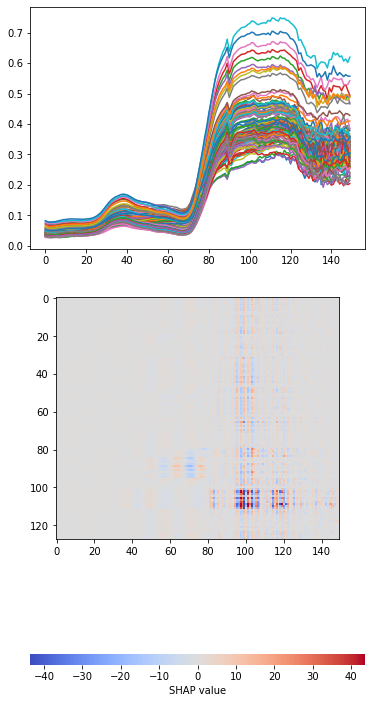

In [13]:
plot_shap_hs(shap_v, -background)